In [2]:
import numpy as np
from collections import defaultdict
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## Example 7.1 - n-step TD Methods on 19 states random walk

In [3]:
class DPAgent():
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
    '''
    def __init__(self, states, actions, transition_table, discount_factor):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        # start with stochastic policy
        self.policy = {}
        for state in states:
            self.policy[state] = [(action, 1/len(self.actions[state])) for action in self.actions[state]]
        self.V = defaultdict(lambda : 0)
        self.discount_factor = discount_factor
    
    def evaluate_policy(self, threshold, verbose=False):
        while True:
            delta = 0
            oldV = copy.deepcopy(self.V)
            for state in self.states:
                v = self.V[state]
                newV = 0
                for action, prob in self.policy[state]:
                    for transition, next_state, reward in self.transition_table[(state, action)]:
                        newV += prob * transition * (reward + self.discount_factor * oldV[next_state])
                self.V[state] = newV
                delta = max(delta, abs(v - self.V[state]))
            if verbose:
                print(self.V)
            if delta < threshold:
                break
                
    def improve_policy(self):
        did_change = False
        for state in self.states:
            best_action = None
            best_value = -1000
            for action in self.actions[state]:
                action_value = 0
                for transition, next_state, reward in self.transition_table[(state, action)]:
                    action_value += transition * (reward + self.discount_factor * self.V[next_state])
                    if action_value > best_value:
                        best_action = action
                        best_value = action_value
            newPolicy = [(action, 1) if action == best_action else (action, 0) for action in self.actions[state]]
            if not all([na == oa and nv == ov for (na, nv), (oa, ov) in zip(newPolicy, self.policy[state])]):
                did_change = True
            self.policy[state] = newPolicy
        return did_change
            
                
    def iterate_policy(self):
        did_change = True
        while did_change:
            self.evaluate_policy(1e-10)
            did_change = self.improve_policy()
        

In [14]:
class RandomWalk:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['l', 'r']
    
    def __init__(self, no_of_states = 19):
        self.no_of_states = no_of_states
        self.start_state = int(self.no_of_states/2)
        self.states = range(no_of_states + 1) # last state is dummy
        self.actions_per_state = defaultdict(lambda : ['l', 'r'])
        self.transition_table = {}
        for state in self.states:
            for action in self.actions_per_state[state]:
                if state == self.no_of_states - 1 and action == 'r':
                    self.transition_table[state, action] = [(1, self.no_of_states, 1)] # go to dummy state
                elif state == 0 and action == 'l':
                    self.transition_table[state, action] = [(1, self.no_of_states, -1)]
                elif state == self.no_of_states:
                    self.transition_table[state, action] = [(1, self.no_of_states, 0)]
                else:
                    self.transition_table[state, action] = [(1, state + ( 1 if action == 'r' else -1), 0)]
    
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if self.state == 0 and action == 'l':
            return self.state, -1, True
        elif self.state == self.no_of_states - 1 and action == 'r':
            return self.state, 1, True
        else:
            self.state += 1 if action == 'r' else -1
            return self.state, 0, False

In [15]:
randomwalk_env = RandomWalk(19)

In [16]:
random_walk_dp_agent = DPAgent(randomwalk_env.states, randomwalk_env.actions_per_state, randomwalk_env.transition_table, 1)

In [17]:
random_walk_dp_agent.evaluate_policy(1e-30)

In [21]:
actual_v = np.array([random_walk_dp_agent.V[state] for state in range(19)])

In [56]:
class TDAgent:
    def __init__(self, env, policy, alpha, n, discount=1, init_v = None):
        self.env = env
        self.policy = policy # is a function
        self.actions = env.actions
        self.V = defaultdict(lambda : init_v if init_v else 0)
        self.discount = discount
        self.alpha = alpha
        self.init_v = init_v
        self.n = n
    
    def evaluate(self, episodes):
        for i in range(episodes):
            t = 0
            T = 1000000
            rewards = {}
            states = {}
            state = self.env.start()
            states[t] = state
            while True:
                if t < T:
                    action = self.policy(state)
                    next_state, reward, is_end = self.env.act(action)
                    rewards[t + 1] = reward
                    states[t+1] = next_state
                    if is_end:
                        T = t + 1
                    state = next_state
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0;
                    for i in range(tau + 1, min(tau + self.n, T) + 1):
                        G += self.discount**(i - tau - 1) * rewards[i]
                    if tau + n < T:
                        G += self.discount ** self.n * self.V[states[tau + n]]
                    self.V[states[tau]] += self.alpha * (G - self.V[states[tau]])
                if tau == T - 1:
                    break
                t += 1

In [69]:
alpha_error = defaultdict(list)
for n in [1, 2, 4,8, 64, 128, 256, 512]:
    for alpha in np.linspace(0, 1, 11):
        experiment_errors = []
        for i in range(100):
            agent = TDAgent(randomwalk_env, lambda _ : np.random.choice(['l', 'r']), alpha, n, 1, 0)
            errors = []
            for j in range(10):
                agent.evaluate(1)
                v = [agent.V[state] for state in range(19)]
                error = np.sqrt(np.mean(np.square(np.array(v) - actual_v)))
                errors.append(error)
            experiment_errors.append(np.mean(errors))
        alpha_error[n].append((alpha, np.mean(experiment_errors)))

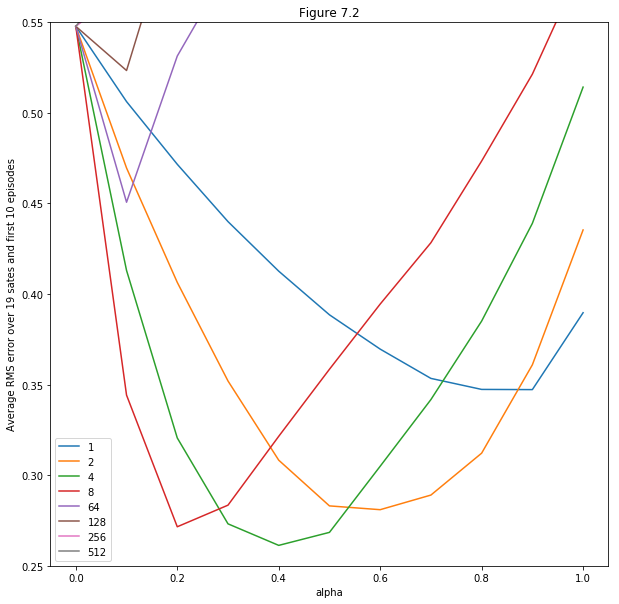

In [72]:
plt.figure(figsize=(10,10))
for n, errors in alpha_error.items():
    plt.plot(*zip(*errors), label=n)
plt.ylabel('Average RMS error over 19 sates and first 10 episodes')
plt.xlabel('alpha')
plt.title('Figure 7.2')
plt.ylim(0.25, 0.55)
plt.legend()